In [1]:
# Using Framingham
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas_profiling
%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\us61565\Desktop\Explainability\Framingham\framingham.csv')

In [3]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
# looking at stats
pandas_profiling.ProfileReport(df)

In [24]:
df['BPMeds'].fillna(0, inplace = True)
df['glucose'].fillna(df.glucose.mean(), inplace = True)
df['totChol'].fillna(df.totChol.mean(), inplace = True)
df['education'].fillna(1, inplace = True)
df['cigsPerDay'].fillna(df.cigsPerDay.mean(), inplace = True)

In [28]:
df['cigsPerDay'][df['currentSmoker']==0].isna().sum()

0

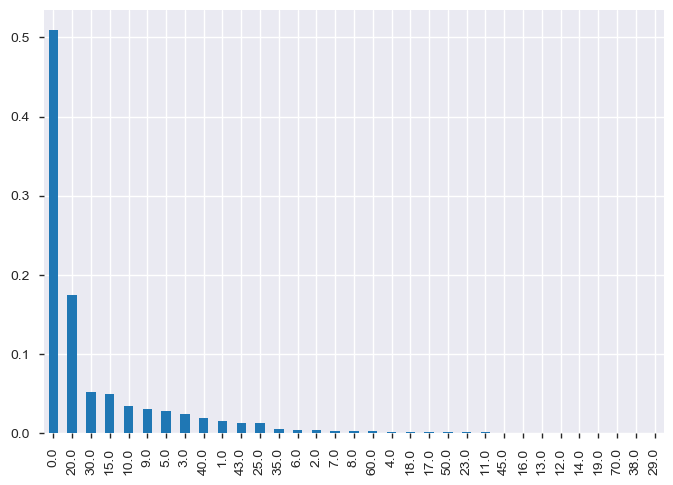

In [26]:
df['cigsPerDay'].value_counts(normalize = True).plot(kind="bar")

In [11]:
df['totChol'].isna().sum()

0

In [7]:
df['BPMeds'].unique()

array([0., 1.])

In [8]:
# # strange column, dropping
# df.drop('education', axis = 1, inplace = True)
# # filling out NaNs with mean
# df.iloc[:,2:] = df.iloc[:,2:].fillna(df.iloc[:,2:].mean())

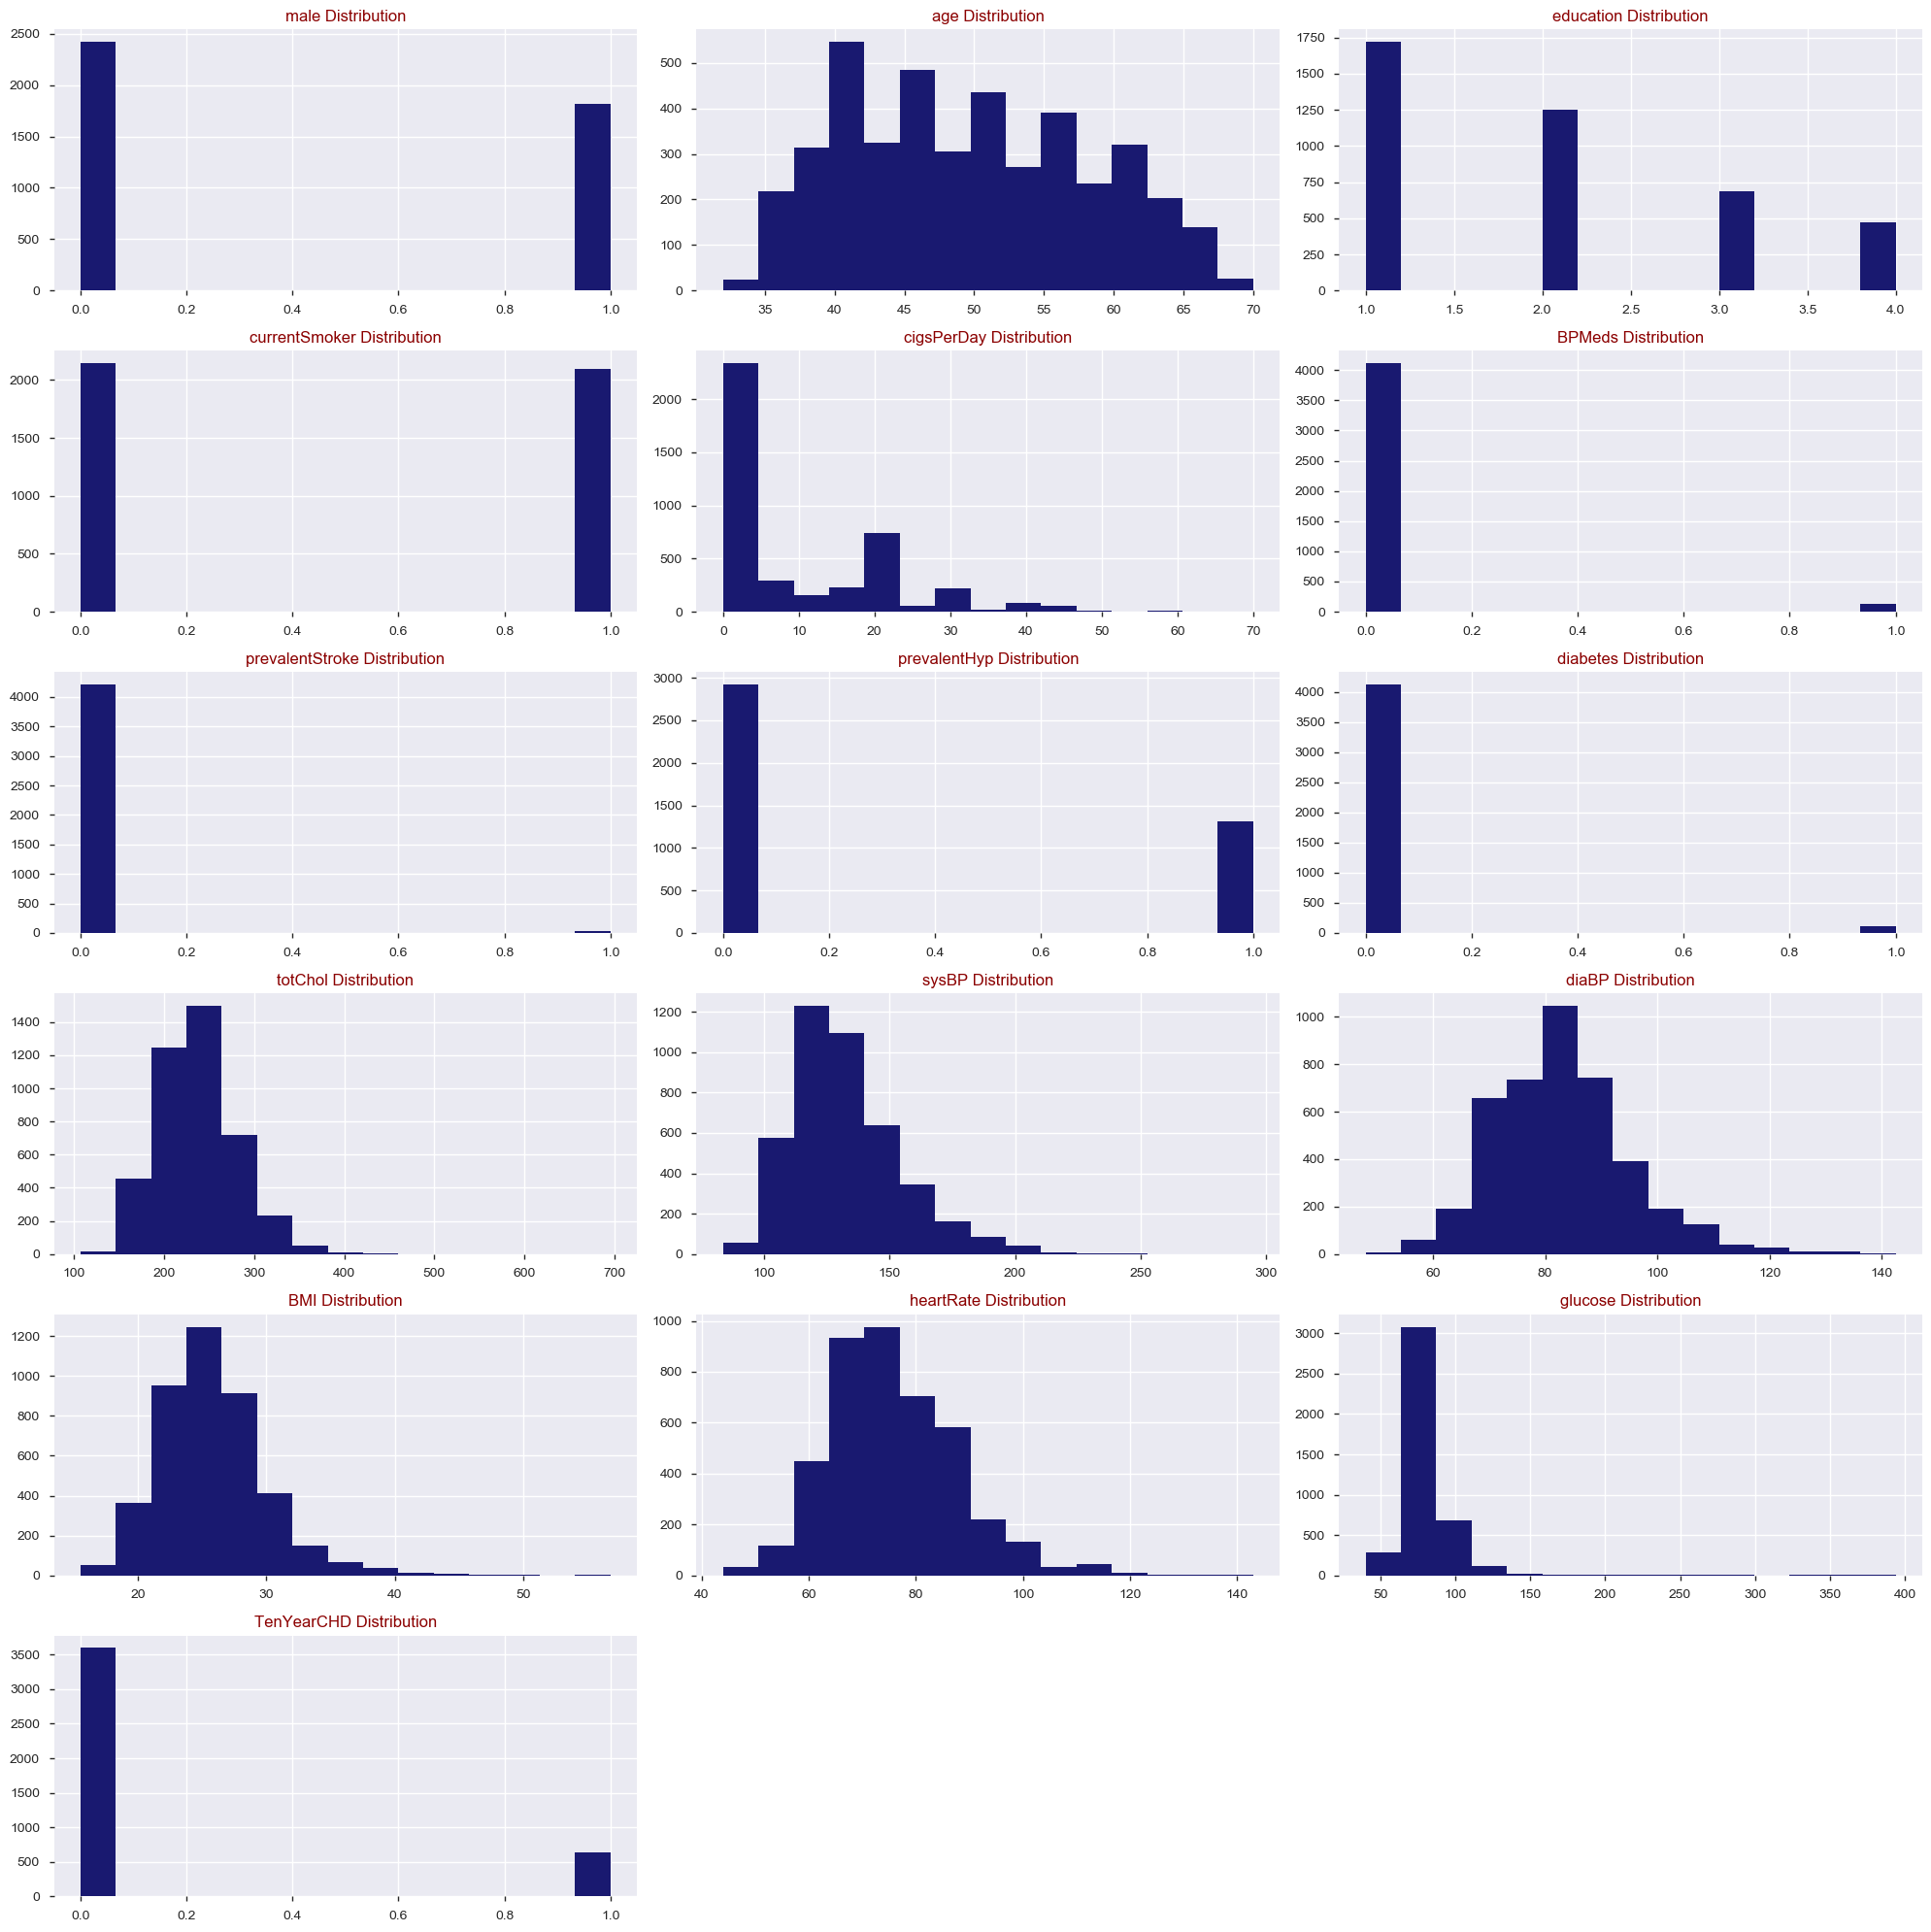

In [9]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=15,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

# might be good to do log on everything later on features

In [10]:
df['TenYearCHD'].value_counts(normalize = True)

0    0.848113
1    0.151887
Name: TenYearCHD, dtype: float64

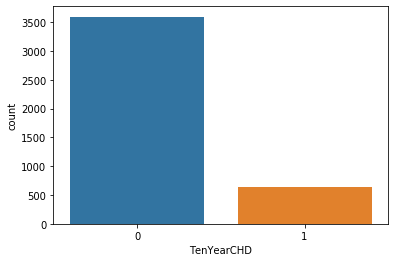

In [10]:
sns.countplot(x='TenYearCHD',data=df)

### A quick baseline

In [13]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [16]:
features = df.iloc[:,:-1]
result = df.iloc[:,-1]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

In [25]:
df.isna().sum()

male                0
age                 0
education           0
currentSmoker       0
cigsPerDay         29
BPMeds              0
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                19
heartRate           1
glucose             0
TenYearCHD          0
dtype: int64

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### Plain vanilla log regression

In [11]:
features = df.iloc[:,:-1]
result = df.iloc[:,-1]

In [12]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

In [14]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train, y_train)
predictions_y_1 = logmodel.predict(X_test)

In [15]:
print(classification_report(y_test, predictions_y_1))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       724
           1       0.57      0.03      0.06       124

    accuracy                           0.85       848
   macro avg       0.71      0.51      0.49       848
weighted avg       0.82      0.85      0.80       848



In [16]:
print(confusion_matrix(y_test, predictions_y_1))

[[721   3]
 [120   4]]


In [17]:
accuracy_score(y_test, predictions_y_1)

0.8549528301886793

In [18]:
# Under ROC curve
prob_y_1 = logmodel.predict_proba(X_test)
prob_y_1 = [p[1] for p in prob_y_1]
print(roc_auc_score(y_test, prob_y_1))

0.7488304223846015


### Same but normalizing features

In [14]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [21]:
logmodel.fit(X_train_std, y_train)
predictions_y_2 = logmodel.predict(X_test_std)

In [22]:
print(classification_report(y_test, predictions_y_2))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.40      0.05      0.09       124

    accuracy                           0.85       848
   macro avg       0.63      0.52      0.50       848
weighted avg       0.79      0.85      0.80       848



In [23]:
print(confusion_matrix(y_test, predictions_y_2))

[[715   9]
 [118   6]]


In [24]:
accuracy_score(y_test, predictions_y_2)

0.8502358490566038

In [25]:
# Under ROC curve
prob_y_2 = logmodel.predict_proba(X_test_std)
prob_y_2 = [p[1] for p in prob_y_2]
print(roc_auc_score(y_test, prob_y_2))

0.7552798075209409


### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
clf = RandomForestClassifier(n_jobs=2, n_estimators=10000, random_state=0)
clf.fit(X_train_std, y_train)
predictions_y_3 = clf.predict(X_test_std)

In [28]:
print(classification_report(y_test, predictions_y_3))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.43      0.05      0.09       124

    accuracy                           0.85       848
   macro avg       0.64      0.52      0.50       848
weighted avg       0.80      0.85      0.80       848



In [29]:
print(confusion_matrix(y_test, predictions_y_3))

[[716   8]
 [118   6]]


In [30]:
accuracy_score(y_test, predictions_y_3)

0.8514150943396226

In [31]:
# Under ROC curve
prob_y_3 = clf.predict_proba(X_test_std)
prob_y_3 = [p[1] for p in prob_y_3]
print(roc_auc_score(y_test, prob_y_3))

0.7295490999821779


In [32]:
# View a list of the features and their importance scores
list(zip(features, clf.feature_importances_))

[('male', 0.020858329086679436),
 ('age', 0.12459753778578027),
 ('currentSmoker', 0.012403990693478249),
 ('cigsPerDay', 0.0540750721531281),
 ('BPMeds', 0.010914756810465802),
 ('prevalentStroke', 0.003566620852565498),
 ('prevalentHyp', 0.017877327365099484),
 ('diabetes', 0.007203912972228973),
 ('totChol', 0.12598687516519325),
 ('sysBP', 0.1387343654186538),
 ('diaBP', 0.11860930157496455),
 ('BMI', 0.13745464602061488),
 ('heartRate', 0.10181375743286156),
 ('glucose', 0.1259035066682863)]

### Feature selection using Random Forest

In [33]:
from sklearn.feature_selection import SelectFromModel

In [34]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.12
sfm = SelectFromModel(clf, threshold=0.12)

# Train the selector
sfm.fit(X_train_std, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10000, n_jobs=2,
                                                 oob_score=False,
                                                 random_state=0, verbose=0,
      

In [ ]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Feature ranking:
1. feature 9 (0.138734)
2. feature 11 (0.137455)
3. feature 8 (0.125987)
4. feature 13 (0.125904)
5. feature 1 (0.124598)
6. feature 10 (0.118609)
7. feature 12 (0.101814)
8. feature 3 (0.054075)
9. feature 0 (0.020858)
10. feature 6 (0.017877)
11. feature 2 (0.012404)
12. feature 4 (0.010915)
13. feature 7 (0.007204)
14. feature 5 (0.003567)


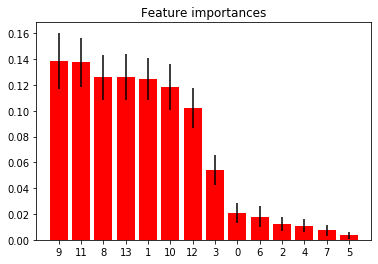

In [36]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train_std.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_std.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_std.shape[1]), indices)
plt.xlim([-1, X_train_std.shape[1]])
plt.show()

In [37]:
# with only imporant features - there are five of them. Can check X_important_train.shape[1]
X_important_train = sfm.transform(X_train_std)
X_important_test = sfm.transform(X_test_std)

In [38]:
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [39]:
predictions_y_4 = clf_important.predict(X_important_test)

In [40]:
print(classification_report(y_test, predictions_y_4))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       724
           1       0.25      0.04      0.07       124

    accuracy                           0.84       848
   macro avg       0.55      0.51      0.49       848
weighted avg       0.77      0.84      0.79       848



In [41]:
print(confusion_matrix(y_test, predictions_y_4))

[[709  15]
 [119   5]]


In [42]:
accuracy_score(y_test, predictions_y_4)

0.8419811320754716

In [43]:
# Under ROC curve
prob_y_4 = clf_important.predict_proba(X_important_test)
prob_y_4 = [p[1] for p in prob_y_4]
print(roc_auc_score(y_test, prob_y_4))

0.6936542060238816


In [44]:
# View a list of the features and their importance scores
list(zip(features, clf_important.feature_importances_))

[('male', 0.16158923018918808),
 ('age', 0.20370546111934634),
 ('currentSmoker', 0.21699117754561678),
 ('cigsPerDay', 0.22994381811240422),
 ('BPMeds', 0.18777031303344477)]

### With XGBoost

In [63]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import graphviz

In [64]:
data_dmatrix = xgb.DMatrix(data=X_train_std,label=y_train)

C:\Users\us61565\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [65]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.08,
                max_depth = 7, alpha = 10, n_estimators = 10)

In [66]:
xg_reg.fit(X_train_std,y_train)
prediction_y_5 = xg_reg.predict(X_test_std)

[09:13:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [67]:
rmse = np.sqrt(mean_squared_error(y_test, prediction_y_5))
print("RMSE: %f" % (rmse))

RMSE: 0.379098


In [68]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[09:13:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [69]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.475893,0.000850,0.476296,0.000780
1,0.455425,0.001483,0.456139,0.001465
2,0.438112,0.002085,0.438978,0.002102
3,0.423468,0.002790,0.424574,0.002747
4,0.410632,0.003107,0.411956,0.003601


In [70]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.345645
Name: test-rmse-mean, dtype: float64


In [71]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[09:13:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [72]:
# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

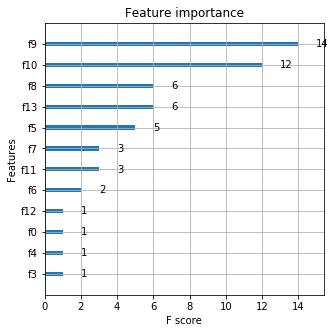

In [73]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()